In [ ]:
#get the dataset
!git clone https://github.com/microsoft/clinical_visit_note_summarization_corpus.git

Cloning into 'clinical_visit_note_summarization_corpus'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 92 (delta 24), reused 66 (delta 14), pack-reused 0
Receiving objects: 100% (92/92), 2.47 MiB | 17.12 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
#dataset path
tdp1="/content/clinical_visit_note_summarization_corpus/data/aci-bench/challenge_data/train.csv"
tdp2="/content/clinical_visit_note_summarization_corpus/data/aci-bench/challenge_data/valid.csv"
tdp3="/content/clinical_visit_note_summarization_corpus/data/aci-bench/challenge_data/clinicalnlp_taskB_test1.csv"
tdp4="/content/clinical_visit_note_summarization_corpus/data/aci-bench/challenge_data/clinicalnlp_taskC_test2.csv"

In [ ]:
#read the data frame
import pandas as pd
df_1=pd.read_csv(tdp1)
df_2=pd.read_csv(tdp2)
df_3=pd.read_csv(tdp3)
df_4=pd.read_csv(tdp4)
# Concatenate the DataFrames vertically (along rows)
data = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   dataset       167 non-null    object
 1   encounter_id  167 non-null    object
 2   dialogue      167 non-null    object
 3   note          167 non-null    object
dtypes: object(4)
memory usage: 5.3+ KB


In [ ]:
data.head()

,dataset,encounter_id,dialogue,note
0,virtassist,D2N001,"[doctor] hi , martha . how are you ?\n[patient...",CHIEF COMPLAINT\n\nAnnual exam.\n\nHISTORY OF ...
1,virtassist,D2N002,"[doctor] hi , andrew , how are you ?\n[patient...",CHIEF COMPLAINT\n\nJoint pain.\n\nHISTORY OF P...
2,virtassist,D2N003,"[doctor] hi , john . how are you ?\n[patient] ...",CHIEF COMPLAINT\n\nBack pain.\n\nHISTORY OF PR...
3,virtassist,D2N004,"[doctor] hi , james , how are you ?\n[patient]...",CHIEF COMPLAINT\n\nBack pain.\n\nHISTORY OF PR...
4,virtassist,D2N005,"[doctor] hey , ms. hill . nice to see you .\n[...",CC:\n\nRight middle finger pain.\n\nHPI:\n\nMs...


In [ ]:
#missing values in dataset
data.isnull().sum()

dataset         0
encounter_id    0
dialogue        0
note            0
dtype: int64

In [ ]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
#from attention import AttentionLayer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Text pre-processing

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    # lower
    newString = text.lower()
    # remove HTML
    newString = BeautifulSoup(newString, "lxml").text
    # Remove any text inside the parenthesis
    newString = re.sub(r'\([^)]*\)', '', newString)
    # remove double quotes
    newString = re.sub('"','', newString)
    # contraction mapping
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    # remove 's
    newString = re.sub(r"'s\b","",newString)
    # Eliminate punctuations and special characters
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Remove stopwords
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    # Remove short words
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

In [ ]:
# Cleaning the "dialogue" Column
cleaned_text = []
for t in data['dialogue']:
    cleaned_text.append(text_cleaner(t,0))

# Cleaning the "note" summary Column
cleaned_summary = []
for t in data['note']:
    cleaned_summary.append(text_cleaner(t,1))
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

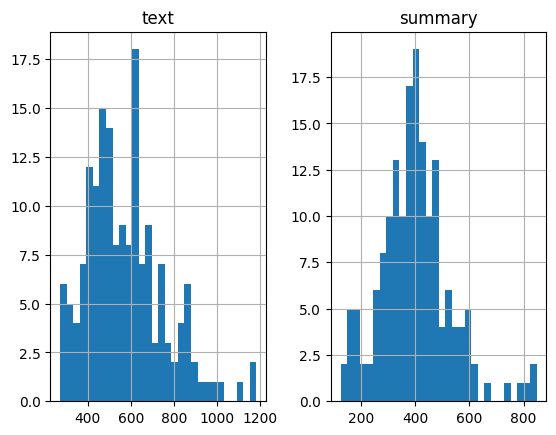

In [ ]:
#the distribution of length of the text
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max_text_len=600
max_summary_len=400 #from histogram

In [ ]:
#new data frame
df=data[['cleaned_summary','cleaned_text']]
df.rename(columns={'cleaned_summary':'summary','cleaned_text':'text'},inplace=True)

In [ ]:
# add the START and END special tokens at the beginning and end of the summary.
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
df.head()

,summary,text
0,sostok chief complaint annual exam history of present illness martha collins is year old female with past medical history significant for congestive heart failure depression and hypertension who p...,doctor hi martha patient okay doctor okay know nurse told dax would like tell dax little bit okay patient okay doctor martha year old female past medical history significant congestive heart failu...
1,sostok chief complaint joint pain history of present illness andrew perez is year old male with past medical history significant for kidney transplant hypothyroidism and arthritis he presents toda...,doctor hi andrew patient hi good see doctor good see well know nurse told dax would like tell dax little bit patient sure doctor okay andrew year old male past medical history significant kidney t...
2,sostok chief complaint back pain history of present illness mr john perry is year old male with past medical history significant for kidney stones migraines and gastroesophageal reflux who present...,doctor hi john patient hey well relatively speaking okay good see doctor good see well know nurse told dax gon na tell dax little bit patient okay doctor john year old male past medical history si...
3,sostok chief complaint back pain history of present illness james allen is year old male with past medical history significant for congestive heart failure and type diabetes who presents today wit...,doctor hi james patient hey good see doctor good see know nurse told dax patient mm hmm doctor would like tell dax little bit patient sure doctor james year old male past medical history significa...
4,sostok cc right middle finger pain hpi ms hill is year old female who presents today for an evaluation of right middle finger pain after she was rear ended in motor vehicle accident she has no oth...,doctor hey ms hill nice see patient hi dr james good see doctor hey dragon seeing ms hill year old female brings today patient um lot pain end right middle finger doctor patient little embarrassin...


## Train-Test Split and Prepare the Tokenizer

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=0, shuffle=True)

### Tokenize the text

In [ ]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

#Rarewords and its Coverage

thresh=3 #Occurance of words less than 3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("Percentage of rare words in vocabulary:", (cnt/tot_cnt)*100)
print("Total Coverage of rare words:", (freq/tot_freq)*100)

# prepare a tokenizer for reviews on training data

x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) # num_words: the maximum number of words to keep, based on word frequency.
x_tokenizer.fit_on_texts(list(X_train))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(X_train)
x_val_seq   =   x_tokenizer.texts_to_sequences(X_test)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print(x_voc)

Percentage of rare words in vocabulary: 52.642973119249504
Total Coverage of rare words: 4.377265816863525
2626


### Tokenize the summary

In [ ]:
#prepare a tokenizer for reviews on training data

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

thresh=6 #Occurance of wrods less than 6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("Percentage of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_train)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_test)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

Percentage of rare words in vocabulary: 73.19905213270142
Total Coverage of rare words: 10.122948051070729


#Model building

In [ ]:
latent_dim = 300
embedding_dim=100

# from tensorflow.keras.layers import AdditiveAttention

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# # Attention layer
# attn_out= AdditiveAttention(use_scale=True)([decoder_outputs, encoder_outputs])

# # Concat attention input and decoder LSTM output
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 600)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 600, 100)             262600    ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 600, 300),           481200    ['embedding[0][0]']           
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

#make the epoch as 50
history=model.fit([x_tr, y_tr[:,:-1]],
                  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                  epochs=50,
                  callbacks=[es],
                  batch_size=6,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:])
                 )

Epoch 1/50
25/25 [==============================] - 123s 4s/step - loss: 5.8045 - val_loss: 5.6192
Epoch 2/50
25/25 [==============================] - 107s 4s/step - loss: 5.2793 - val_loss: 5.5597
Epoch 3/50
25/25 [==============================] - 105s 4s/step - loss: 5.1974 - val_loss: 5.4636
Epoch 4/50
25/25 [==============================] - 105s 4s/step - loss: 4.9172 - val_loss: 5.2755
Epoch 5/50
25/25 [==============================] - 106s 4s/step - loss: 4.8088 - val_loss: 5.2564
Epoch 6/50
25/25 [==============================] - 105s 4s/step - loss: 4.7798 - val_loss: 5.2071
Epoch 7/50
25/25 [==============================] - 107s 4s/step - loss: 4.7445 - val_loss: 5.1741
Epoch 8/50
25/25 [==============================] - 105s 4s/step - loss: 4.7135 - val_loss: 5.1524
Epoch 9/50
25/25 [==============================] - 105s 4s/step - loss: 4.6825 - val_loss: 5.1415
Epoch 10/50
25/25 [==============================] - 104s 4s/step - loss: 4.6490 - val_loss: 5.1072
Epoch 11/

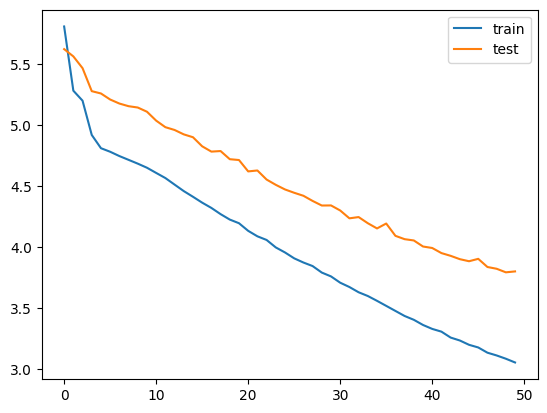

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
#the dictionary to convert the index to word for target and source vocabulary
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

## Inference layer of the encoder and decoder

In [ ]:
from tensorflow.keras.layers import Concatenate, Lambda
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
original_summary=[]
predicted_summary=[]
model_dict={}
for i in range(0,10): #sample subset of data for prediction and evaluation
    original_summary.append(seq2summary(y_tr[i]))
    predicted=decode_sequence(x_tr[i].reshape(1,max_text_len))
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",predicted)
    predicted_summary.append(predicted)
    print("\n")
model_dict['Encoder_decoder']=predicted_summary

1/1 [==============================] - 0s 22ms/step
Review: doctor right today seeing james uh date birth mr james new patient pain left shoulder elbow fell five months ago going stairs pain present since doctor hi mr james doctor patient okay thank doctor good good tell brings today patient sure constant pain left shoulder left elbow five months hurts time pretty bad times doctor mm sound like fun sounds like injured going stairs patient yes correct icy walk stairs house stepped feet went fell left side seems like shoulder wrist took hurting since doctor yeah seem like likely cause symptoms anything seem make pain worse patient well always hit gym lifted weights trying keep routine two days week hard pain worse lift able lift pounds frustrating doctor mm hmm imagine routine patient exactly really enjoy exercise past one two weeks stopped hitting gym pain worth honestly keep walking though wife walk minutes almost every day done since office job last year doctor mr james anything seem 

### T5 Large for Medical Text Summarization

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

tokenizer = AutoTokenizer.from_pretrained("Falconsai/medical_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/medical_summarization")

predicted_summary=[]

for i in range(10):
  input_text=seq2text(x_tr[i])
  # Tokenize the input text
  input_ids = tokenizer.encode(input_text, return_tensors="pt")

  # Generate predictions
  with torch.no_grad():
      output = model.generate(input_ids, max_length=100, num_return_sequences=1)

  # Decode the output
  predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)
  print(predicted_text)
  predicted_summary.append(predicted_text)

Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors


mr james new patient pain left shoulder elbow fell five months ago going stairs pain present since doctor hi mr james doctor patient okay thank doctor good tell brings today patient sure constant pain left shoulder elbow fell five months ago going stairs pain present since doctor hi mr james doctor patient okay thank doctor good tell brings today patient sure constant pain left shoulder elbow fell five months ago going stairs pain present since doctor hi mr james doctor patient okay thank
background : a saturday night saturday nights spicy foods spicy patient yeah doctor okay well gut probably always appreciate patient like doctor yeah ibs one things sensitive certain things spicy foods fatty foods alcohol cause lower belly stuff like cramps get upper belly stuff nausea patient getting doctor okay um frequently getting bowel movement normal days patient starting notice two three times day doctor okay soft stools stools patient um doctor okay go either drinking friends tend diarrhea pat

In [ ]:
model_dict['T5 Large']=predicted_summary

### Google pegasus large

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-large")
model = AutoModelForSeq2SeqLM.from_pretrained("google/pegasus-large")

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
predicted_summary=[]

for i in range(10):
  input_text=seq2text(x_tr[i])
  # Tokenize the input text
  input_ids = tokenizer.encode(input_text, return_tensors="pt")

  # Generate predictions
  with torch.no_grad():
      output = model.generate(input_ids, max_length=100, num_return_sequences=1)

  # Decode the output
  predicted_text = tokenizer.decode(output[0], skip_special_tokens=True)
  print(predicted_text)
  predicted_summary.append(predicted_text)

doctor right today seeing james uh date birth mr james new patient pain left shoulder elbow fell five months ago going stairs pain present since doctor hi mr james doctor patient okay thank doctor good good tell brings today patient sure constant pain left shoulder left elbow five months hurts time pretty bad times doctor mm sound like fun sounds like injured going stairs patient yes correct icy walk stairs house stepped feet went fell left side seems like shoulder wrist took hurting since doctor yeah seem like likely cause symptoms anything seem make pain worse patient well
nights saturday nights spicy foods spicy patient yeah doctor okay well gut probably always appreciate patient like doctor yeah ibs one things sensitive certain things spicy foods fatty foods alcohol cause lower belly stuff like nausea get upper belly stuff nausea patient getting doctor okay um frequently getting bowel movement normal days patient starting notice two three times day doctor okay soft stools stools pa

In [ ]:
model_dict['Google pegasus']=predicted_summary

### Models evaluation and comparative analysis

In [ ]:
!pip -qq install rouge

In [ ]:
import nltk
import editdistance
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate import bleu_score
from rouge import Rouge
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def evaluation_metrix(original_texts,predicted_texts):
  # Lists to store scores
  bleu_scores = []
  rouge_scores = []
  levenshtein_distances = []

  # Calculate BLEU score, ROUGE score, and Levenshtein distance for each pair
  for original_text, predicted_text in zip(original_texts, predicted_texts):
      # BLEU Score
      reference = [nltk.word_tokenize(original_text)]
      candidate = nltk.word_tokenize(predicted_text)
      score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method4)
      bleu_scores.append(score)

      # ROUGE Score
      rouge = Rouge()
      rouge_score = rouge.get_scores(predicted_text, original_text, avg=True)
      rouge_scores.append(rouge_score['rouge-l']['f'])

      # Levenshtein Distance
      levenshtein_distance = editdistance.eval(original_text, predicted_text)
      levenshtein_distances.append(levenshtein_distance)

  # Calculate means
  mean_bleu = sum(bleu_scores) / len(bleu_scores)
  mean_rouge = sum(rouge_scores) / len(rouge_scores)
  mean_levenshtein = sum(levenshtein_distances) / len(levenshtein_distances)
  return {
       "Mean BLEU Score":mean_bleu,
       "Mean ROUGE Score": mean_rouge,
       "Mean Levenshtein Distance:":mean_levenshtein
  }

In [ ]:
evaluation_metrix_dict={}
for model_name in model_dict.keys():
  evaluation_metrix_dict[model_name]=evaluation_metrix(original_summary,model_dict[model_name])
evaluation_metrix_dict

In [ ]:
import pandas as pd
import seaborn as sns
evaluation_df=pd.DataFrame(evaluation_metrix_dict).T
evaluation_df.head()

,Mean BLEU Score,Mean ROUGE Score,Mean Levenshtein Distance:
Encoder_decoder_model,0.043410,0.206630,1545.1
T5 Large,0.001078,0.072195,1580.1
Google pegasus,0.002597,0.093679,1486.6


<Axes: xlabel='Mean BLEU Score', ylabel='None'>

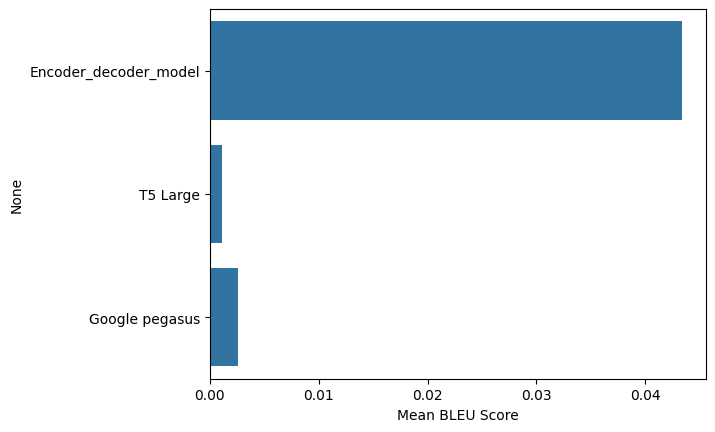

In [ ]:
sns.barplot(x='Mean BLEU Score',y=evaluation_df.index,data=evaluation_df)

<Axes: xlabel='Mean ROUGE Score', ylabel='None'>

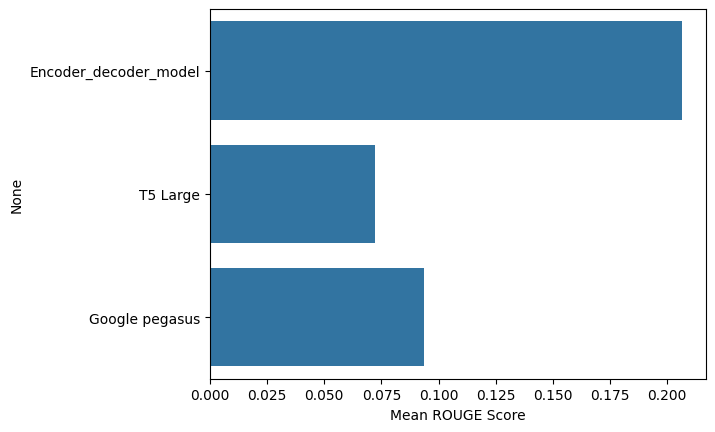

In [ ]:
sns.barplot(x='Mean ROUGE Score',y=evaluation_df.index,data=evaluation_df)

<Axes: xlabel='Mean Levenshtein Distance:', ylabel='None'>

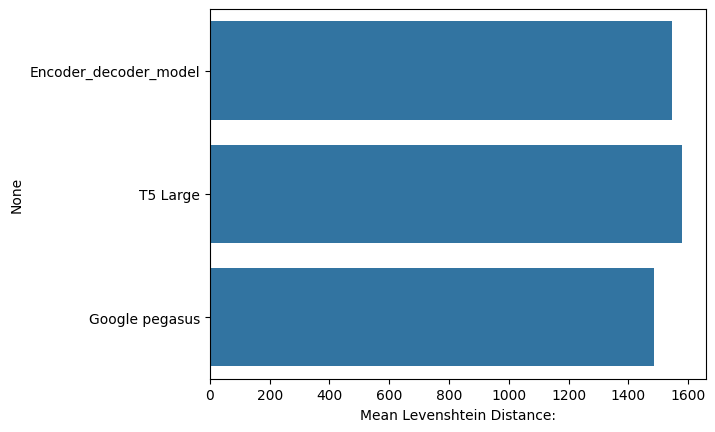

In [ ]:
sns.barplot(x='Mean Levenshtein Distance:',y=evaluation_df.index,data=evaluation_df)